# Generative Adversarial Networks for Robust Covariance Matrix and PCA 
 

In [1]:
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt
import time
import os

import numpy as np
import pandas as pd
import scipy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Normal

from fgan import fgan

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
use_gpu = torch.cuda.is_available()

device = torch.device('cuda:2' if use_gpu else 'cpu')

%load_ext autoreload
%autoreload 2

In [2]:
corps_dict = {
         "Industrial":["LMT", "HON", "UNP", "BA", "MMM", "UPS"],
         "ConsDiscr":["AMZN", "HD", "MCD", "NKE", "SBUX", "LOW"],
         "ConsStaples":["WMT", "PG", "KO", "PEP", "COST", "PM"],
         "Energy":["XOM", "CVX", "COP", "VLO", "EOG"],
         "HealthCare":["JNJ", "UNH", "MRK", "PFE", "ABT", "LLY"],
         "Financial":["JPM", "BAC", "WFC", "C", "AXP", "BLK"],
         "InfoTech":["MSFT", "AAPL", "MA", "INTC", "CSCO"],
         "Material":["LIN", "ECL", "APD", "NEM", "SHW", "DD"],
         "Utility":["NEE", "D", "DUK", "SO", "AEP", "SRE"],
         "CommSevs": ["GOOG", "VZ", "T", "DIS", "NFLX"]
            }

corps = []; sects = [] ## list of corporations and their corresponding sectors
for k, v in corps_dict.items():
    corps += v[:5]
    sects += [k] * 5

tks = yf.Tickers( " ".join(corps) )

START = "2007-01-01"; END = "2019-01-01"
df_price = tks.history(start=START, end=END)["Close"]

[*********************100%***********************]  50 of 50 completed


# Visualize the return of stocks selected from different sectors

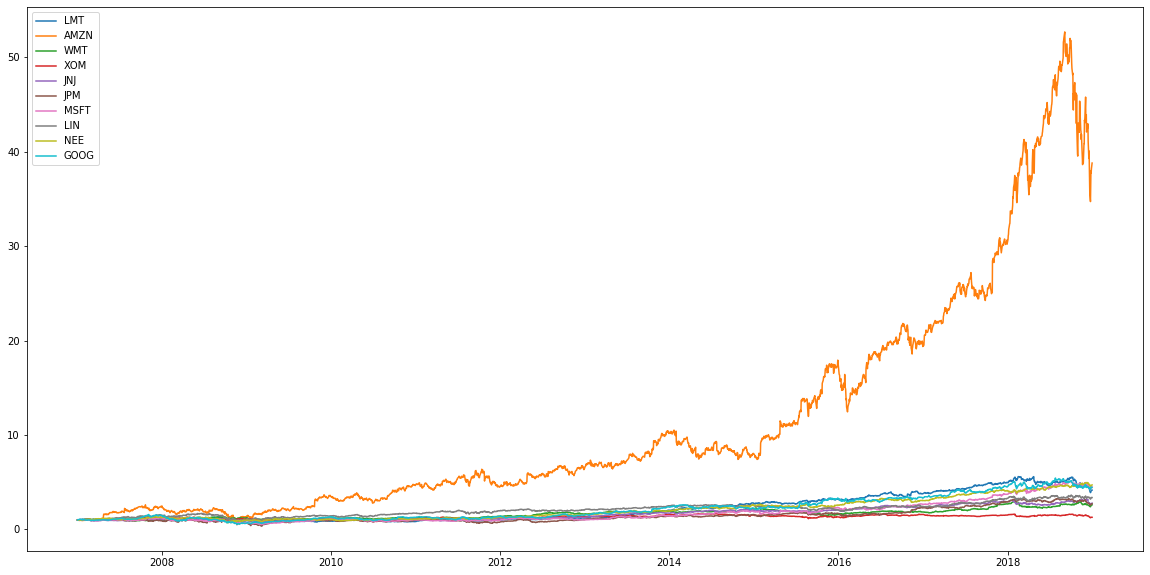

In [3]:
fig, ax = plt.subplots(figsize=(20,10))

for sym in list(zip(*corps_dict.values()))[0]:
    ax.plot(df_price[sym]/df_price[sym].iloc[0], label=sym)
ax.legend()
plt.show()

In [4]:
df_ret = df_price/df_price.shift(1) # daily return
dropIdx = df_ret["AAPL"].index[ df_ret["AAPL"].apply( np.isnan ) ]
df_ret = df_ret.drop( dropIdx )
logret = np.log( df_ret.to_numpy() ) # daily log-return
logret = logret / logret.std() # re-scale
logret_tensor = torch.from_numpy( logret ).float()

Epoch:250, LossD/G:1.3594/-0.6755


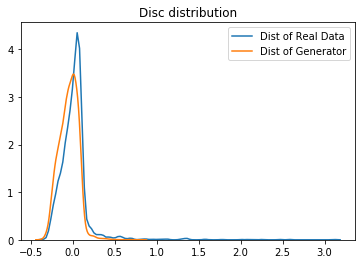

Epoch:500, LossD/G:1.3192/-0.6605


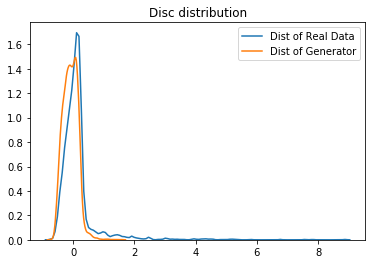

Epoch:750, LossD/G:1.2602/-0.6025


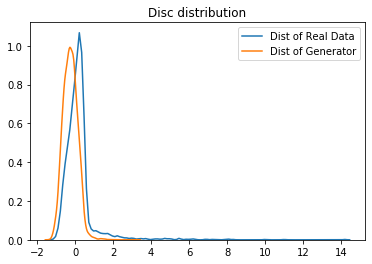

Epoch:1000, LossD/G:1.2622/-0.6516


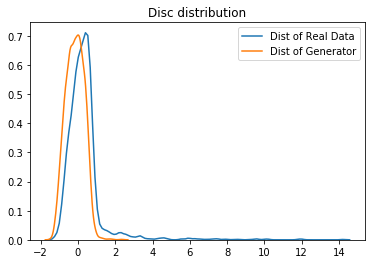

Epoch:1250, LossD/G:1.2299/-0.5940


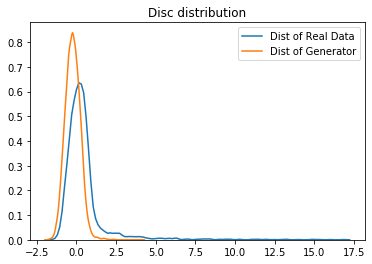

Epoch:1500, LossD/G:1.1053/-0.5016


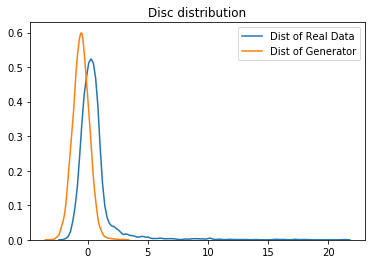

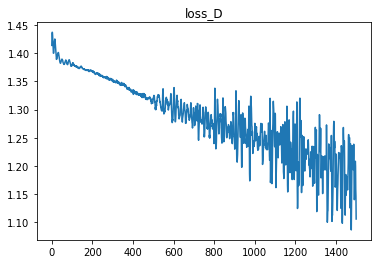

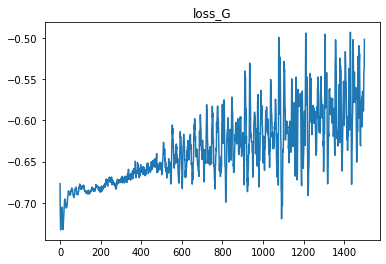

Time for running this cell: 1075.61s


In [5]:
## Fitted by Gaussian
s0 = time.time()
f1 = fgan(50, 0.0, device, epsilon=1e-5)
f1.dist_init(true_type='Gaussian', cont_type='Gaussian',
             c_cov=1.0, c_loc=1.0)
f1.data_init(batch_size=25, data=logret_tensor)
f1.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f1.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f1.fit(floss='js', epochs=1500, avg_epochs=50,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

Epoch:250, LossD/G:1.3828/-0.6960


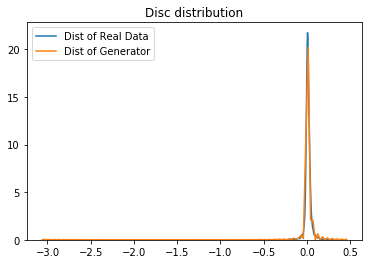

Epoch:500, LossD/G:1.3744/-0.6885


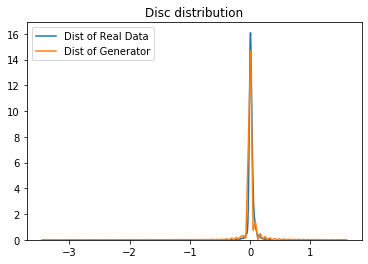

Epoch:750, LossD/G:1.3664/-0.6877


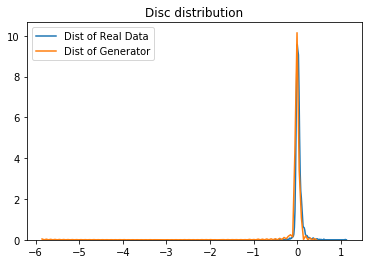

Epoch:1000, LossD/G:1.3456/-0.6765


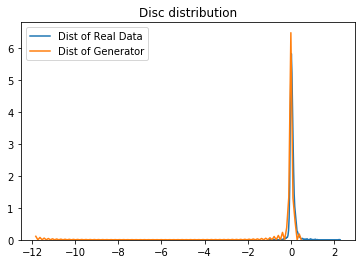

Epoch:1250, LossD/G:1.3345/-0.6696


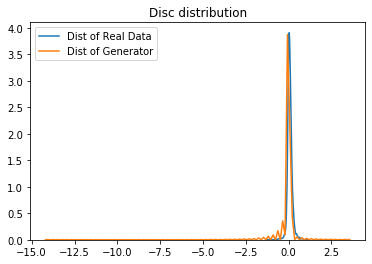

Epoch:1500, LossD/G:1.3148/-0.6667


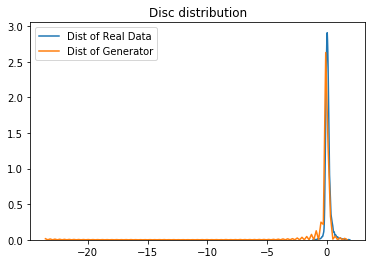

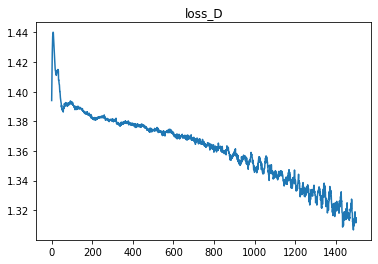

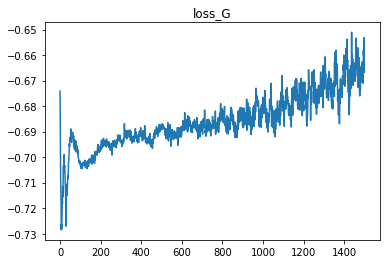

Time for running this cell: 592.55s


In [6]:
## Fitted by Student-t
s0 = time.time()
f2 = fgan(50, 0.0, device, epsilon=1e-5)
f2.dist_init(true_type='Student', t_df=2, cont_type='Gaussian',
            c_cov=5.0, c_loc=5.0)
f2.data_init(batch_size=50, data=logret_tensor)
f2.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f2.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f2.fit(floss='js', epochs=1500, avg_epochs=50,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

Epoch:250, LossD/G:1.3807/-0.6922


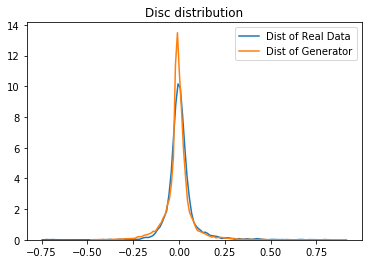

Epoch:500, LossD/G:1.3729/-0.6870


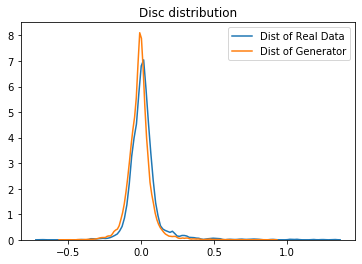

Epoch:750, LossD/G:1.3689/-0.6855


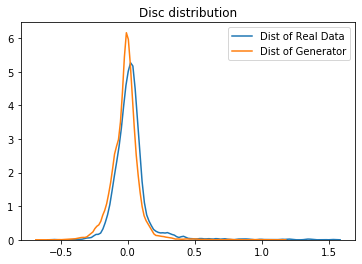

Epoch:1000, LossD/G:1.3568/-0.6819


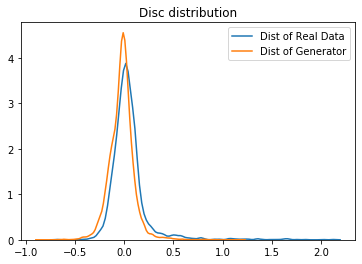

Epoch:1250, LossD/G:1.3484/-0.6754


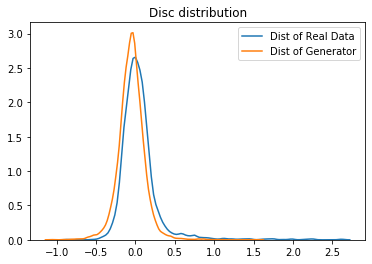

Epoch:1500, LossD/G:1.3458/-0.6805


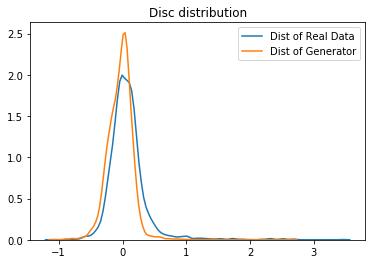

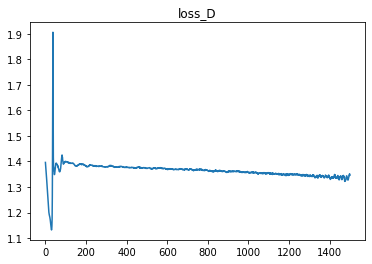

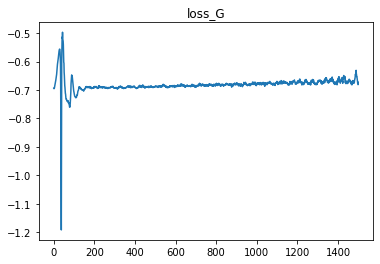

Time for running this cell: 622.62s


In [7]:
## Fitted by Elliptical
s0 = time.time()
f3 = fgan(50, 0.0, device, epsilon=1e-5)
f3.dist_init(true_type='Student', t_df=2, cont_type='Gaussian',
            c_cov=5.0, c_loc=5.0)
f3.data_init(batch_size=50, data=logret_tensor)
f3.net_init(hidden_units=[100, 25], hidden_units_G=[25, 10], input_dim_G=10, use_bias=True,
            elliptical=True, init_D='xavier', init_D1=0.025, init_G='kendall',
            activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f3.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f3.fit(floss='js', epochs=1500, avg_epochs=50, inverse_gaussian=False,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

## Outlier detection by Discriminator

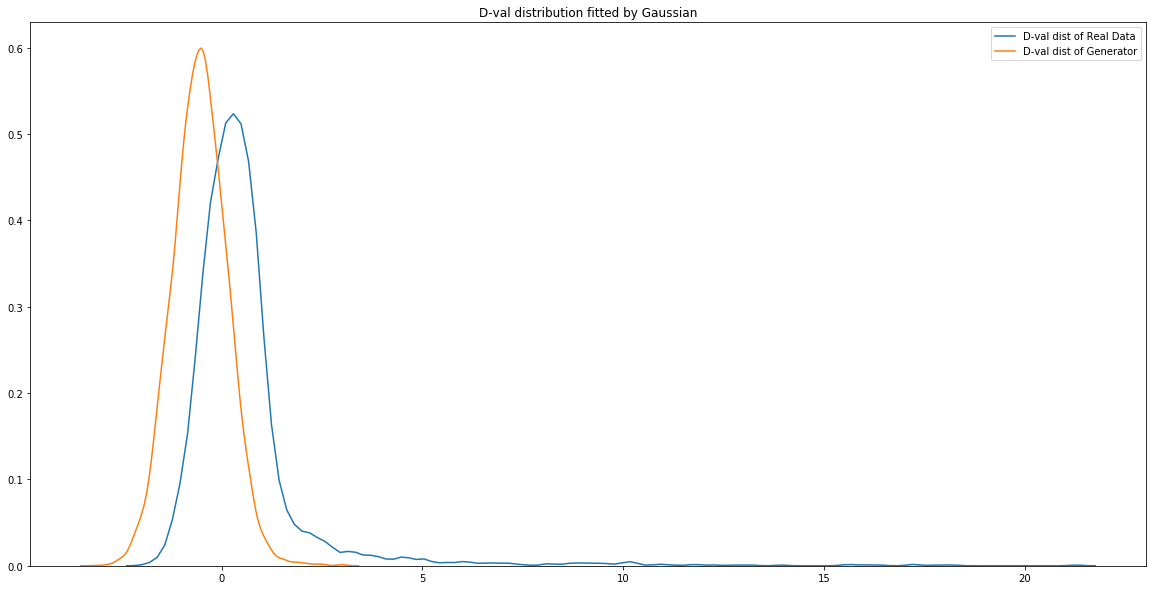

277 outliers are detected by Gaussian fit


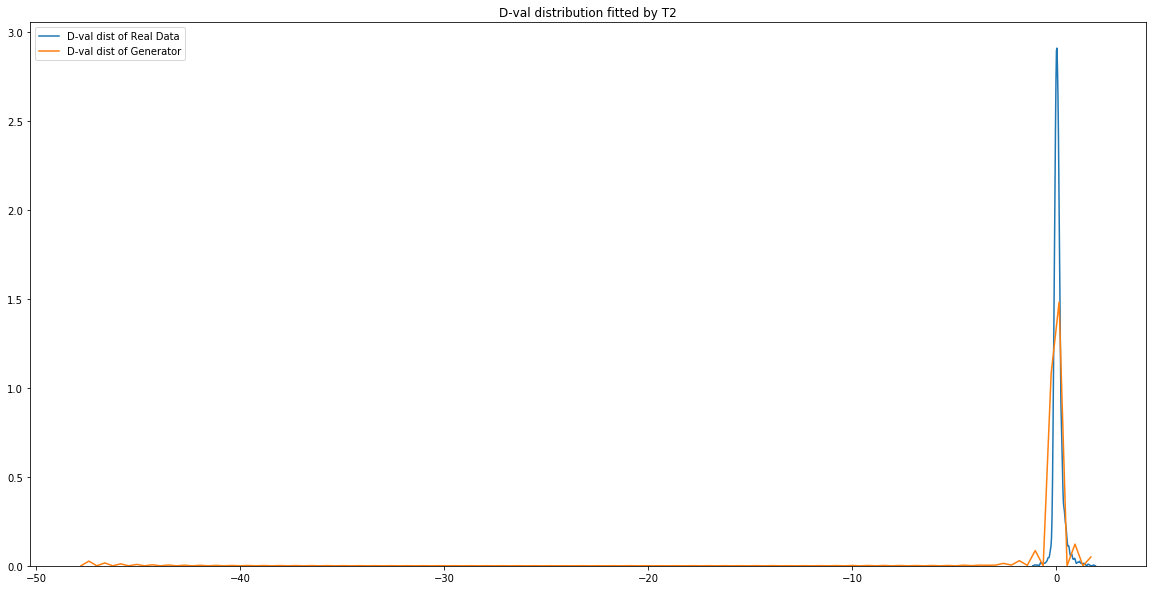

92 outliers are detected by T2 fit


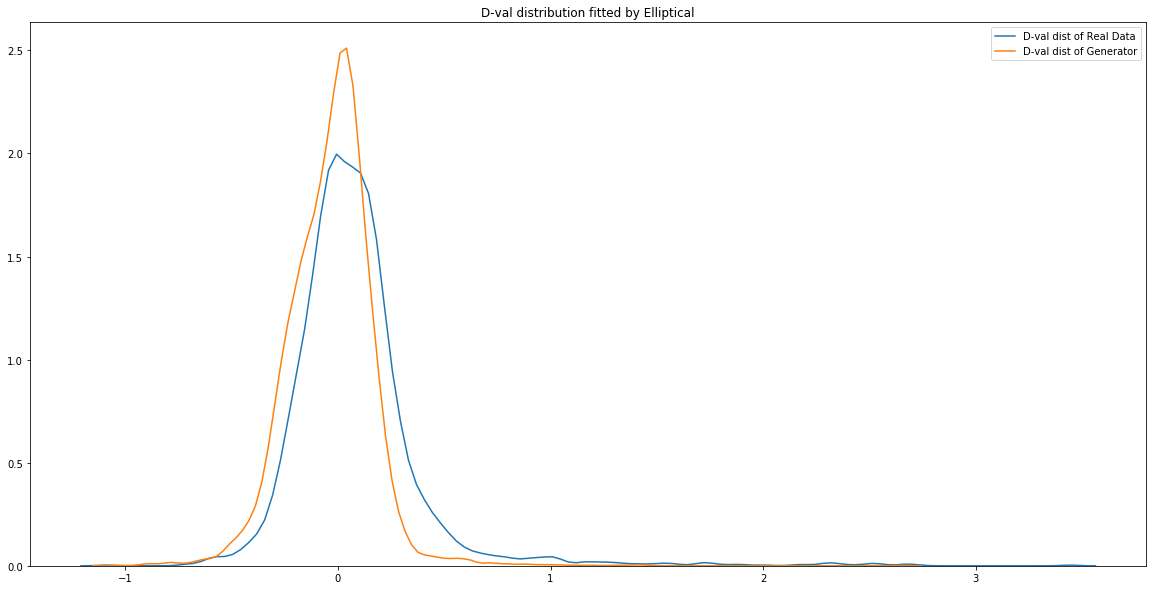

98 outliers are detected by Elliptical fit


In [8]:
outlierIndex = {}
model = ['Gaussian', 'T2', "Elliptical"]

for i in range(3):
    f = eval("f"+str(i+1))
    fig, ax = plt.subplots(figsize=(20,10))

    real_D = f.netD(f.Xtr.to(device))[1].detach().cpu().numpy()
    ## generating sample score
    if not f.elliptical:
        if f.true_type == 'Student':
            temp_z = torch.randn(10000, f.p).to(device) # [N, p]
            temp_z.div_(torch.sqrt(f.t_chi2_d.sample((10000, 1))/f.t_df).to(device) + f.epsilon)
            temp_g = f.netG(temp_z)
        elif f.true_type == 'Gaussian':
            temp_g = f.netG(torch.randn(10000, f.p).to(device))

    else:
        temp_u = torch.randn(10000, f.p).to(device)
        temp_u.data.div_(temp_u.norm(2, dim=1).view(-1, 1) + f.epsilon)
        if f.inverse_gaussian:
            temp_xi1 = torch.randn(10000, f.input_dim_G//2).to(device)
            temp_xi2 = torch.randn(10000, f.input_dim_G//2).to(device)
            temp_xi2.data = 1/(torch.abs(temp_xi2.data) + f.epsilon)
            temp_xi = f.netGXi(torch.cat([temp_xi1, temp_xi2], dim=1)).view(10000, -1)
        else:
            temp_xi = f.netGXi(torch.randn(10000, f.input_dim_G).to(device)).view(10000, -1)
        temp_g = f.netG(temp_u, temp_xi)

    gene_D = f.netD(temp_g)[1].detach().cpu().numpy()

    sns.distplot(f.real_D, hist=False, label='D-val dist of Real Data')
    sns.distplot(f.gene_D, hist=False, label='D-val dist of Generator')
    plt.legend()
    plt.title('D-val distribution fitted by ' + model[i])
    plt.show()
    
    # outlier is defined as data with discriminator value larger(smaller) than
    # 99.75(1) percentile estimated from learned generator.
    outlierIndex[i] = (real_D > np.percentile(gene_D, 99.75)) | (real_D < np.percentile(gene_D, 1))
    print( "{} outliers are detected by {} fit".format( outlierIndex[i].sum(), model[i]) )
    #print(np.std(gene_D))



In [9]:
spx = yf.Ticker( "^GSPC")
df_spx = spx.history(start=START, end=END)["Close"]

In [11]:
## Import S&P 500 Index and see what happens at outlier date.
import pandas_datareader.data as web
import datetime

SPX = web.DataReader(['sp500'], 'fred', START, END)
SPX = SPX.loc[df_ret.index[1000:]]

spx = yf.Ticker( "^GSPC")
df_spx = spx.history(start=START, end=END)["Close"]
df_spx = df_spx[df_ret.index]

/home/yuany/.conda/envs/mypython3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


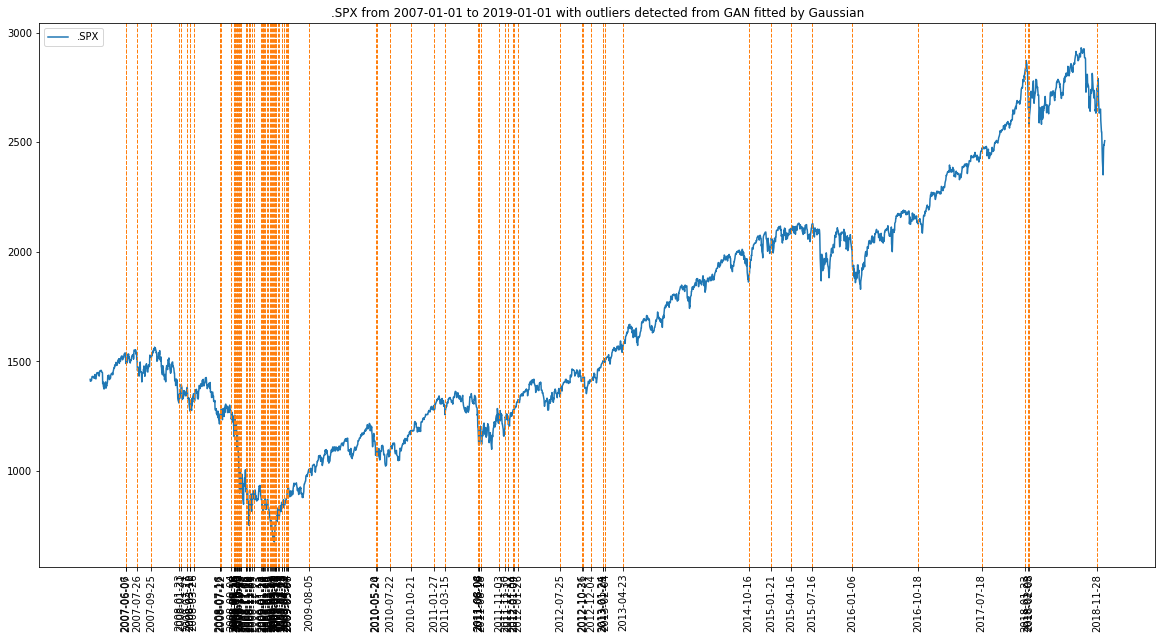

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_spx, label=".SPX")
outlierDate = df_spx.index[outlierIndex[2]].tolist()
for idx in outlierDate:
    ax.axvline(x=idx, color='C1', linestyle='--', lw=1.0)
tickList = outlierDate
plt.xticks(outlierDate, [ x.strftime("%Y-%m-%d") for x in outlierDate ], rotation=90)
ax.legend()
ax.set_title( ".SPX from {} to {} with outliers detected from GAN fitted by Gaussian".format(START, END) )
plt.show()

## Robust PCA

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit( logret )

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

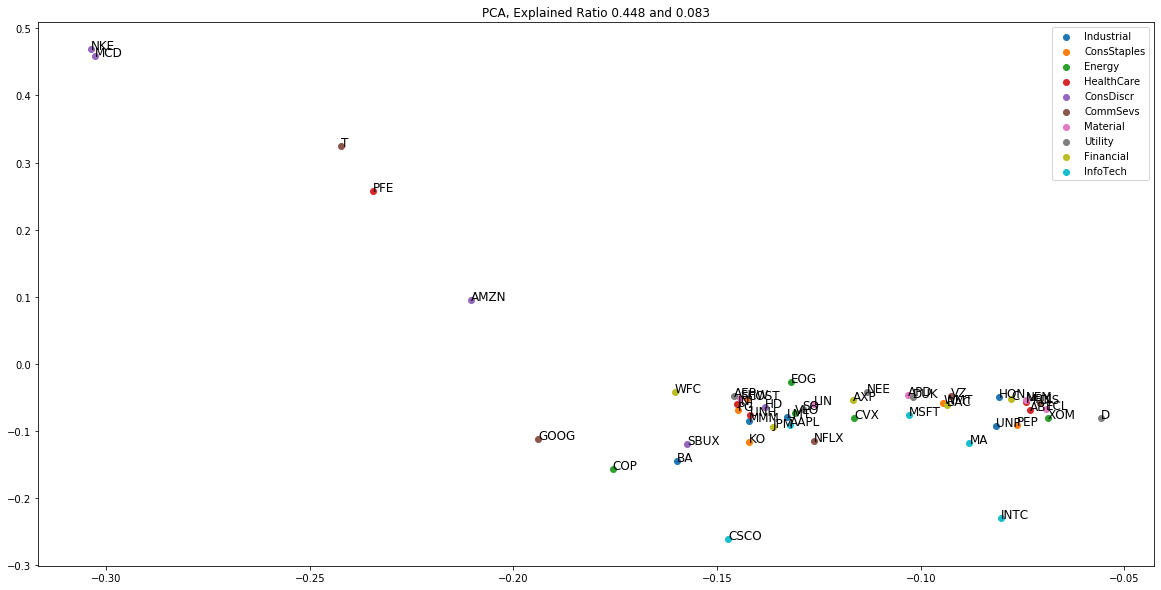

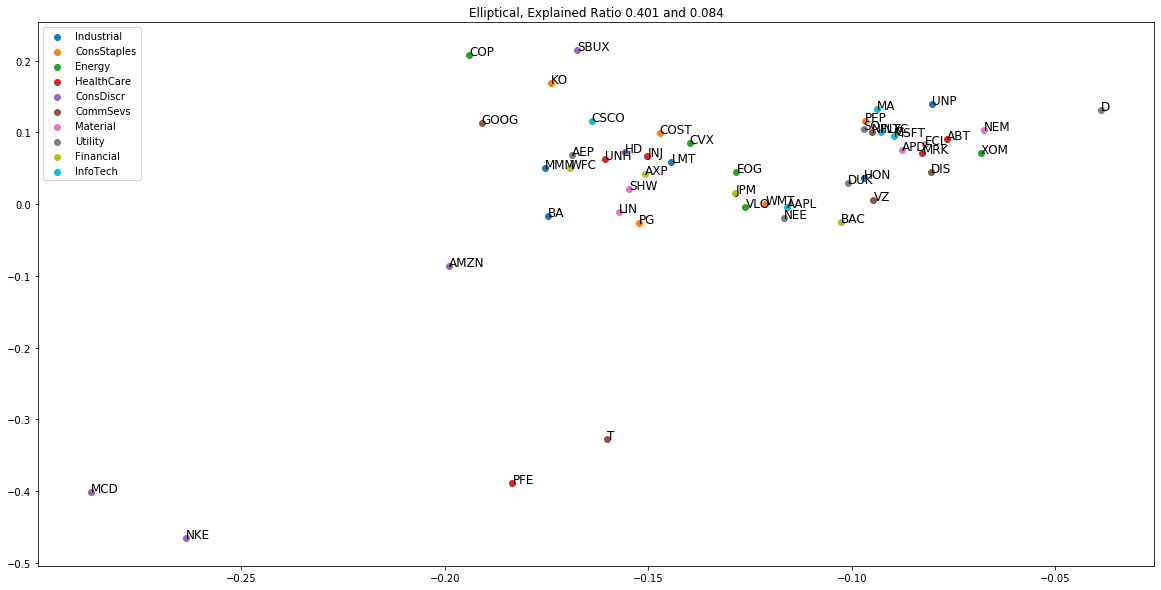

In [14]:
cov0 = pca.get_covariance()
s0, v0 = scipy.linalg.eigh(cov0)
fig, ax = plt.subplots(figsize=(20,10))
for sect in set(sects):
    idx = (np.array(sects) == sect)
    ax.scatter(v0[idx,-1], v0[idx,-2], label=sect)
for i, txt in enumerate(corps):
    ax.annotate(txt, (v0[:,-1][i], v0[:,-2][i]),size=12)
plt.legend()
plt.title('PCA, Explained Ratio %.3f and %.3f' % ((s0/s0.sum())[-1], (s0/s0.sum())[-2]))
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
f = eval("f"+str(3))
A = f.netG.weight.data.cpu().numpy()
cov = np.matmul(A.T, A)
s, v = scipy.linalg.eigh(cov)
for sect in set(sects):
    idx = (np.array(sects) == sect)
    ax.scatter(v[idx,-1], v[idx,-2], label=sect)
for i, txt in enumerate(corps):
    ax.annotate(txt, (v[:,-1][i], v[:,-2][i]),size=12)
plt.legend()
plt.title(model[2] + ', Explained Ratio %.3f and %.3f' % 
          ((s/s.sum())[-1], (s/s.sum())[-2]))
plt.show()



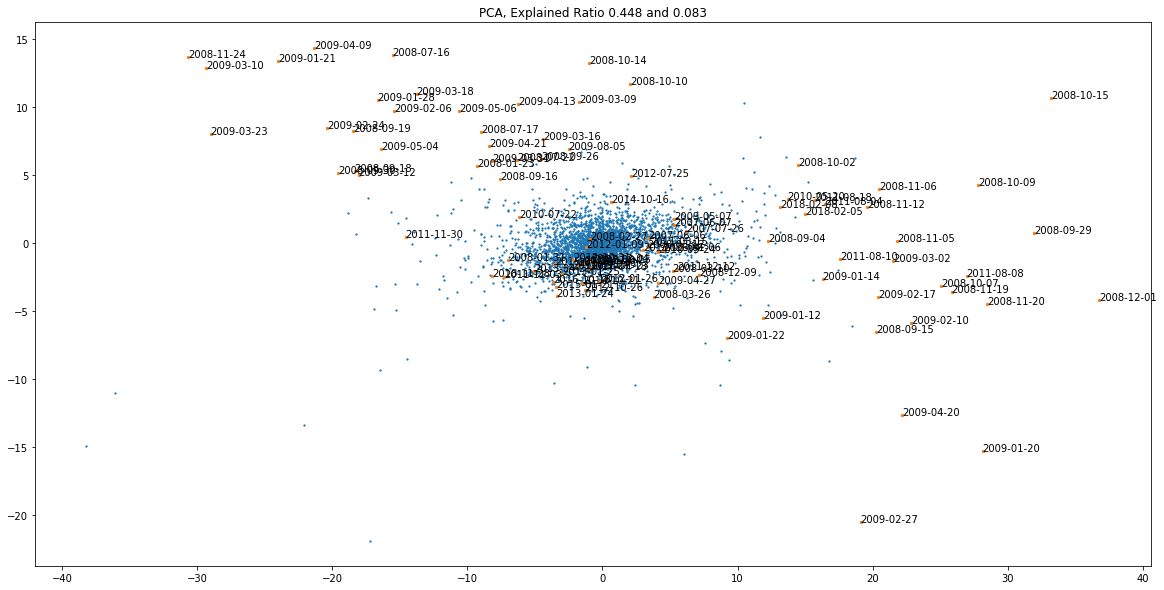

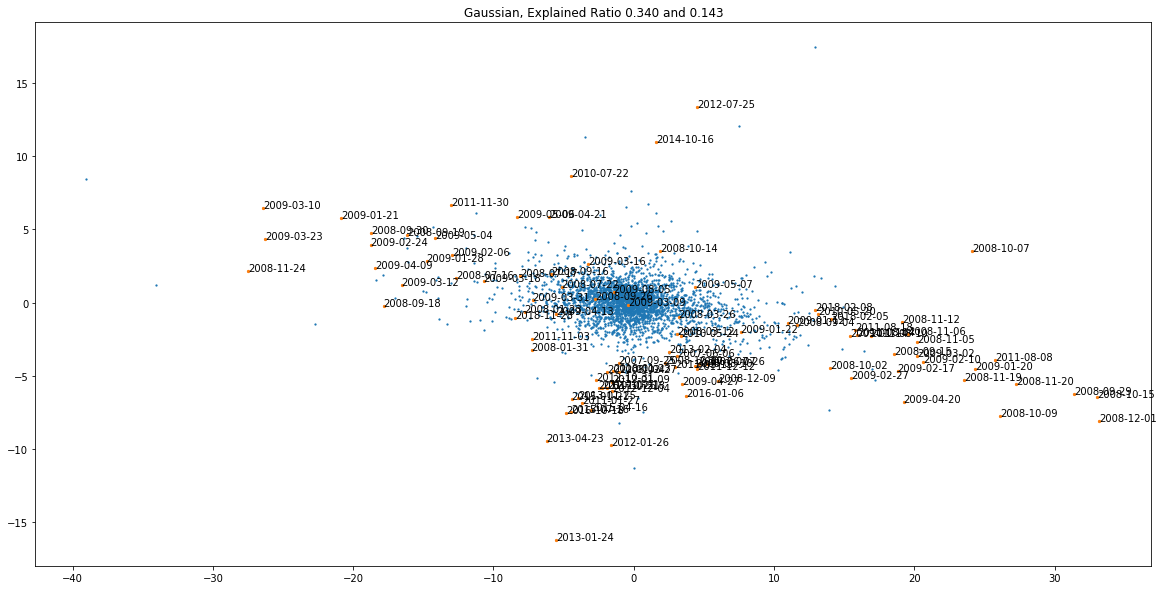

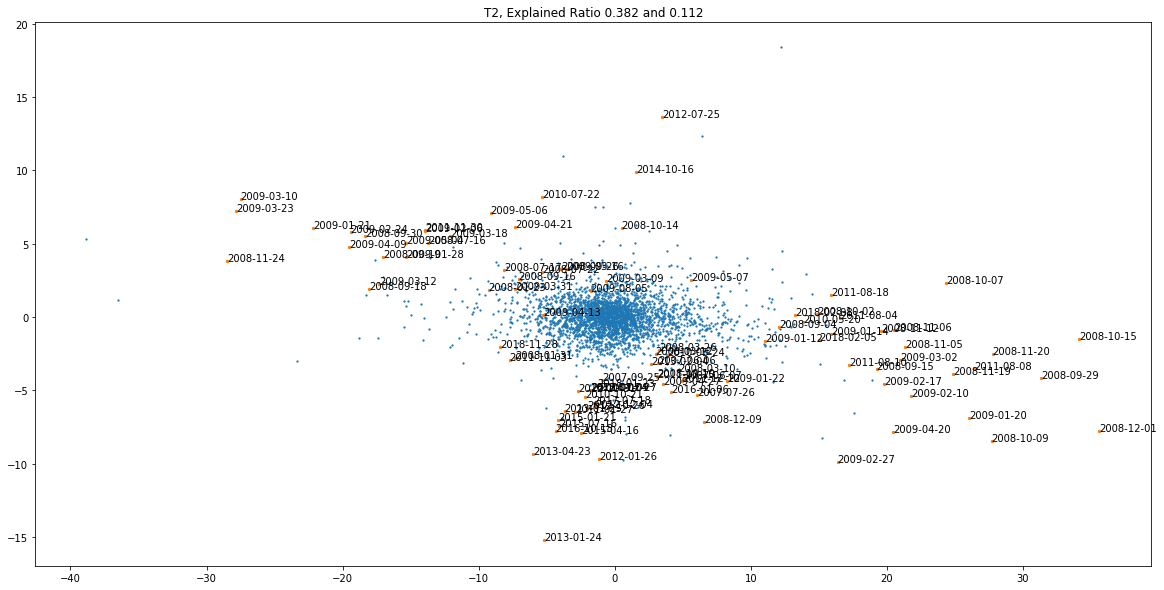

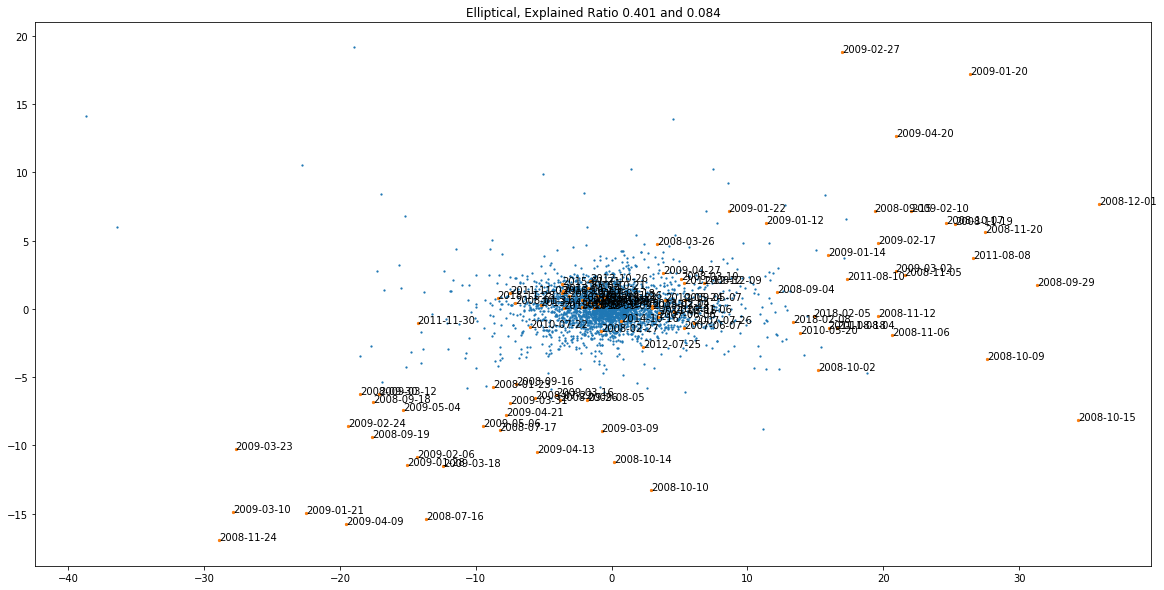

In [15]:
## visualize outliers on 2-dim pca 
fig, ax = plt.subplots(figsize=(20,10))
cov0 = pca.get_covariance()
s0, v0 = scipy.linalg.eigh(cov0)
Xf0 = np.matmul(logret, v0[:,[-1,-2]]) # Xf_0: n by 2
plt.scatter(Xf0[:,0], Xf0[:,1],s=1.5)
plt.scatter(Xf0[outlierIndex[2],0], Xf0[outlierIndex[2],1], s=5)
for idx in np.arange(len(Xf0))[outlierIndex[2]]:
    ax.annotate( df_ret.index[idx].strftime("%Y-%m-%d"), (Xf0[idx,0], Xf0[idx,1]))
plt.title('PCA, Explained Ratio %.3f and %.3f' % ((s0/s0.sum())[-1], (s0/s0.sum())[-2]))
plt.show()

for j in range(3):
    f = eval("f"+str(j+1))
    fig, ax = plt.subplots(figsize=(20,10))
    A = f.netG.weight.data.cpu().numpy()
    cov = np.matmul(A.T, A)
    s, v = scipy.linalg.eigh(cov)
    Xf = np.matmul(logret, v[:,[-1,-2]])
    plt.scatter(Xf[:,0], Xf[:,1],s=1.5)
    plt.scatter(Xf[outlierIndex[2],0], Xf[outlierIndex[2],1], s=5)
    for idx in np.arange(len(Xf))[outlierIndex[2]]:
        ax.annotate( df_ret.index[idx].strftime("%Y-%m-%d"), (Xf[idx,0], Xf[idx,1]))
    plt.title(model[j] + ', Explained Ratio %.3f and %.3f' % 
              ((s/s.sum())[-1], (s/s.sum())[-2]))
    plt.show()
